### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [3]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set([j for i in lines for j in i])

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [4]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {tokens[i]:i for i in range(len(tokens))}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [6]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [7]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:

class ConvPaddedBlock(nn.Module):
    def __init__(self,input_dim,hidden_dim,n_pad,n_layers):
        super().__init__()
        layers = nn.ModuleList()
        self.pad = nn.ZeroPad2d((n_pad,0,0,0))
        self.beta = nn.Parameter(torch.Tensor([0.5])) # it might help
        for i in range(n_layers-1):
            layers.append(self.pad)
            if i == 0:
                layers.append(nn.Conv1d(input_dim,hidden_dim,n_pad+1)) # kernel_size == pad_length+1 in order to involve each token
            else:
                layers.append(nn.Conv1d(hidden_dim*(2**(i-1)),hidden_dim*(2**i),n_pad+1))   
        layers.append(self.pad) # keeping sequence length with padding after every convolution
        layers.append(nn.Conv1d(hidden_dim*(2**i),input_dim,n_pad+1)) # return to the embedding dim
        
        self.seq = nn.Sequential(*layers)
    
    def forward(self,x):
        return self.beta*self.seq(x)+(1-self.beta)*x #residual

class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64,n_prev = 5,n_layers = 5):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        self.embeddings = nn.Embedding(n_tokens,emb_size,0)
        self.block = ConvPaddedBlock(emb_size,hid_size,n_prev,n_layers)
        
        
        #END OF YOUR CODE
    
    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above

        out_embs = self.block(self.embeddings(input_ix).permute(0,2,1)) #(3,16,15) @ (136,16)
        
        
        return out_embs.permute(0,2,1)@self.embeddings.weight.T # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(self.embeddings.weight.device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).to(self.embeddings.weight.device).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [10]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('embeddings.weight', 'block.beta', 'block.seq.1.weight', 'block.seq.1.bias', 'block.seq.3.weight', 'block.seq.3.bias', 'block.seq.5.weight', 'block.seq.5.bias', 'block.seq.7.weight', 'block.seq.7.bias', 'block.seq.9.weight', 'block.seq.9.bias')


In [11]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [12]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [13]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [14]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    device = next(model.parameters()).device
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:].long().to(device)
    loss_fn = nn.CrossEntropyLoss()
    loss = 0
    logits *= compute_mask(logits).to(device)
    for i in range(logits.shape[0]):
        loss+=loss_fn(logits[i],reference_answers[i])

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    
    
    return loss/(i+1)

    

In [15]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [16]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [23]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel(hid_size=16).to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridginggggggggg///βββββββββββββββββββββVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV


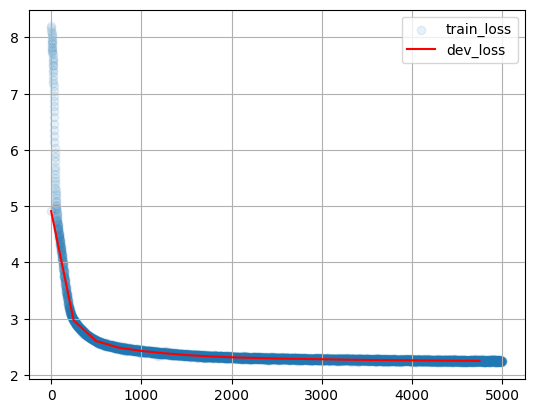

Generated examples (tau=0.5):
 Mention bation thor chally condicale s and angent and are cament and and tion sif chare tarding the 
 Thermente seprimethat ond proplisint ons pored ta n atee tor senter ale carnento 

 Thitrel ind Retions ons work teve the were non the precemenend ro he poral Seston by inticaling ale 
Scoring dev...


100%|██████████| 5000/5000 [17:05<00:00,  4.87it/s]

#4999 Dev loss: 2.248


In [348]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    batch = torch.tensor(batch).to(device)
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [351]:
model.block.beta

Parameter containing:
tensor([0.6937], device='cuda:0', requires_grad=True)

In [356]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 2.247616803006428
 A Hored Recles ing arking urale mation tha s for the bere pored tor ofice pores in the s an meding t
 Thiticulang are propertion ant ation lute paspor ind the cothes for tren ing antien tron of rathing 
 Sederon mat on the Eration sone thel probed for chered lation barel are condinting anding remplesest
 Enation the lempion vowitha f the cofor unce pore nf at on int capereation of the meane modiction ta
 Anitus properectithe derke for are and oral torit on the promation s animicita filating ion blaralio
 Prop Mpjecention con antity ang tintis ing deng antion umales ons ang es ond tion ang tise nont inal
 Intere the probestion of orethe chare thar pormenor and the dation the comporitin the sempres indent
 Sesint uen tho the bation sfor tor and the corconstis inge the pres ras ing peprene thas of the an p
 Tromaling moraling anconction s aralliming poratising at int ons dation dod the sesting the then are
 Concons ang ationd for the the terate procastit

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [18]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256,dropout = 0.5,device = 'cuda'):
        self.device = device
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        
        self.lstm = nn.LSTM(emb_size,hid_size,batch_first=True,num_layers=3,dropout=dropout)
        self.embeddings = nn.Embedding(n_tokens,emb_size,0)
        self.fc = nn.Linear(hid_size,n_tokens)
        
        #END OF YOUR CODE
    
    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above

        out = self.lstm(self.embeddings(input_ix))[0]
        out = self.fc(out)
        
        return out
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(self.device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).to(self.device).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [19]:
model = RNNLanguageModel()
model.eval()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'embeddings.weight', 'fc.weight', 'fc.bias')


In [20]:
# test for lookahead

dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [24]:
batch_size = 256         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 5
train_history, dev_history = [], []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNNLanguageModel(device = device).to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingωãx|h,j:LŁæ_°εγβgk<[γ"çωsIê'eïâ!μQn;`eáeŁ7β7æeGτEadá.(ïG2çt3P;/βfnνDÜc/ZχF!â.âr%E4n_σX|/ofk


In [25]:
from torch.utils.data import DataLoader

In [26]:
def collate(x):
    return torch.Tensor(to_matrix(x))
loader = DataLoader(train_lines,batch_size=batch_size,shuffle=True,collate_fn=collate,drop_last=True)

In [27]:
for x in loader:
    break

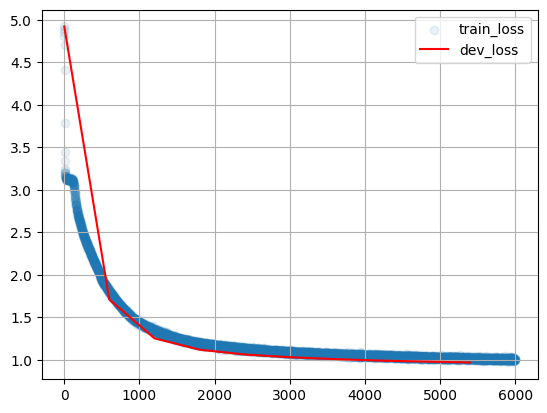

Generated examples (tau=0.5):
 Unsupervised Entropy Image Recognition ; The introduction of a structure of the image reconstruction
 The Statistical Model of Sparse Inference ; This paper presents a novel approach to use the developm
 Machine learning in Neural Networks for Visual Engineering ; This paper presents a novel method for 
Scoring dev...
#5999 Dev loss: 0.962


In [29]:
from IPython.display import clear_output
from random import sample
from tqdm import tqdm
EPOCHS = 50


for epoch in range(EPOCHS):
    model.train()
    for i,batch in enumerate(tqdm(loader,desc = f'{epoch}/{EPOCHS}')):
        opt.zero_grad()
        batch = batch.to(device)
        loss_i = compute_loss(model,batch)
        loss_i.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1, norm_type=2.0, error_if_nonfinite=False, foreach=None)
        train_history.append((len(loader)*epoch+i, loss_i.item()))
        opt.step()
    model.eval()
    
    clear_output(True)
    with torch.no_grad():
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
            
        if (epoch + 1) % score_dev_every == 0:
            print("Scoring dev...")
            dev_history.append((len(loader)*epoch+i, score_lines(model, dev_lines, batch_size)))
            print('#%i Dev loss: %.3f' % dev_history[-1])


In [30]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
gen = generate(model, temperature=0.5,prefix= BOS,max_len=2000)
gen = gen.split()
for i in range(10):
    print(" ".join(gen[len(gen)//10*i:len(gen)//10*(i+1)]))

Final dev loss: 0.9620711388239046
A Comparison of Neural Networks for Differential Networks ; We give an artificial
neural network (DNN) in the results of the controlled framework to discover a
set of problems. In this paper, we propose a novel method to provide
a simple survey of learning of the state of the second of the
targets for semantic supervised methods. The logical system is to define similar independence
in the attention framework for representing a neural network (CNN) for recognition of
a text with the context of the task. We propose a novel approach
to general segmentation algorithms for an extraction of an image analysis of the
resulting problem in the input of the adversarial model by an effective corpus.
In this paper, we describe a method to achieve the problem of strong


### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [31]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)
        tokens = np.array(tokens)
        idx = np.argsort(probs)[::-1]
        if probs[idx[0]] > nucleus:
            probs = [probs[idx[0]]]
            tokens = [tokens[idx[0]]]
        else:
            idx = idx[np.cumsum(probs[idx])<nucleus]
            probs = probs[idx]
            tokens = tokens[idx]
        probs = probs/sum(probs)
        next_token =  np.random.choice(tokens,p=probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len:
            return prefix
        
        
        


<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17052\2110154991.py:2: SyntaxWarning: invalid escape sequence '\i'
  """


In [32]:
from decimal import Decimal
for i in range(10):
    print(round(1-i/10,1), " : ", generate_nucleus(model,nucleus=1-i/10))

1.0  :   Generation of Sparse Minimal Networks ; This paper presents a new linear framework, which key data-d
0.9  :   Performance Relationships for Translation of Person Minimization and   Exploration ; We present a no
0.8  :   Multiple Constraints with Sparse Text Registration ; In this paper, we propose a deep learning probl
0.7  :   Inferring Training Deep Reinforcement Learning for Convolutional Neural   Networks ; Specifically, t
0.6  :   The Relationship of Semantic Models for Multi-agent Approaches ; In this paper, we propose a novel a
0.5  :   Deep Learning for Deep Learning ; The problem of several approaches for experiments of a deep learni
0.4  :   A Multi-View Segmentation Algorithm for Deep Learning ; We present a novel method for computer visio
0.3  :   Semantic Segmentation of Convolutional Neural Networks ; We present a novel approach to the context 
0.2  :   A Semantic Approach to Statistical Models for Semantic Segmentation ; We present a novel approach to
0.1  :   A

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [33]:
from IPython.display import HTML
# Here's what it looks like:
# !wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [34]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    """
    prefixes = [prefix for i in range(beam_size)]
    cum_probs = np.zeros(beam_size)

    finished_sentences = []
    finished_probs = []

    for i in range(beam_size):
        token_probs = model.get_possible_next_tokens(prefixes[i])
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)
        tokens = np.array(tokens)
        idx = np.argsort(probs)[-1-i]
        probs = cum_probs[i] + np.log(probs[idx])
        prefixes[i] = prefixes[i] + tokens[idx]


    
    for e in range(length):
        current_prefixes = []
        current_probs = []
        for i in range(len(prefixes)):
            token_probs = model.get_possible_next_tokens(prefixes[i])
            if e == length-1:
                token = EOS
                prob = token_probs[EOS]
                finished_probs.append(prob)
                finished_sentences.append(prefixes[i]+" " + token)
            else:
                tokens, probs = zip(*token_probs.items())
                probs = np.array(probs)
                tokens = np.array(tokens)
                idx = np.argsort(probs)[::-1]
                idx = idx[:beam_size]
                probs = probs[idx]
                tokens = tokens[idx]
                for j in range(beam_size):
                    if tokens[j] == EOS:
                        finished_sentences.append(prefixes[i]+ tokens[j])
                        finished_probs.append(cum_probs[i] + np.log(probs[j]))
                    else:
                        current_probs.append(cum_probs[i]  + np.log(probs[j]))
                        current_prefixes.append(prefixes[i]+ tokens[j])
                        
        if e == length-1:
            max_probs_ids = np.argsort(np.array(finished_probs)[::-1][:beam_size])
            return np.array(finished_sentences)[max_probs_ids]
        
        max_probs_ids = np.argsort(np.array(current_probs)[::-1][:beam_size])



        for j in range(beam_size):
            prefixes[j] = current_prefixes[max_probs_ids[j]]
            cum_probs[j] = current_probs[max_probs_ids[j]]
            

    
    

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17052\3502066314.py:2: SyntaxWarning: invalid escape sequence '\i'
  """


In [47]:
for i in generate_beamsearch(model,'Deep Learning', beam_size=4,length=200):
    print(i)

Deep Learning and Statistical Models:

Deep Learning and Statistical Models (CNNs) are a computational model.

Deep Learning and Statistical Models (CNNs) are a computatio

Deep Learning and Statistical Models.



In [49]:
for i in generate_beamsearch(model,prefix = 'Deep learning', beam_size=1,length=200):
    print(i)

Deep learning algorithms for the problem of computer vision and semantic segmentation and semantic segmentation and semantic segmentation and semantic segmentation and semantic segmentation and semantic segmentati 



In [53]:
for i in generate_beamsearch(model, beam_size=4,length=200):
    print(i)

 A Semantic Approach to Statistical Models for Semantic Segmentation ; We present a novel approach to the problem of semantic segmentation.

 A Semantic Approach to Statistical Models for Semantic Segmentation ; We present a novel approach to the problem of semantic segmentatio

 A Semantic Approach to Statistical Models for Semantic Segmentation ; We present a novel approach to the problem,

 A Semantic Approach to Statistical Models for Semantic Segmentation ; We present a novel approach.



In [60]:
for i in generate_beamsearch(model,prefix = 'scum of the aeon ', beam_size=1,length=200):
    print(i)

scum of the aeon and the state-of-the-art approaches for the problem of computer vision and semantic segmentation and semantic segmentation and semantic segmentation and semantic segmentation and semantic segmentation 



In [61]:
for i in generate_beamsearch(model,prefix = 'scum of the aeon ', beam_size=8,length=200):
    print(i)

scum of the aeon and the state-of-the-art approache,

scum of the aeon and the state-of-the-art appr

scum of the aeon and the state-of-the-art approache.

scum of the aeon and the state-of-the-art approach.

scum of the aeon and the state-of-the-art.

scum of the aeon and the state-of-the-art approaches,

scum of the aeon and th

scum of the aeon and the state-of-the-art approach:



In [38]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_